In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")


In [88]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [89]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [90]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [91]:
df1 = df["tweets"]
df2 = df["label"]

In [92]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)
tweets = list(tweets_tratados)

In [93]:
tweets_tratados.isnull().sum()

0

In [94]:
label_encoder = preprocessing.LabelEncoder()
labels = pd.DataFrame(label_encoder.fit_transform(df2), columns=["Label"], index = df.index)
labels

,Label
0,2
1,1
2,1
3,1
4,0
...,...
18104,2
18105,2
18106,0
18107,3


In [95]:
labels.value_counts()

Label
2        8385
1        4819
3        2961
0        1944
dtype: int64

In [96]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [97]:
y.shape

(18109, 4)

In [98]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [99]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11579 unique tokens.


In [100]:
# integer encode the documents
sequences = tokenizer.texts_to_sequences(tweets)

In [101]:
# pad documents to a max length of 14 words
maxlen = 28
X = pad_sequences(sequences, maxlen=maxlen)

In [102]:
X.shape

(18109, 28)

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [104]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12676, 28), (5433, 28), (12676, 4), (5433, 4))

In [105]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen = maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [106]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 28, 32)            370560    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 28, 32)            2080      
                                                                 
 dropout_8 (Dropout)         (None, 28, 32)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 28, 32)            2080      
                                                                 
 dropout_9 (Dropout)         (None, 28, 32)            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 4)                

In [107]:
model.save('srnn.h5')

In [108]:
start = time.time()

# Fit the model to the training set
rnn_hist = model.fit(X_train, y_train, epochs=3, validation_split=0.3)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/3
278/278 [==============================] - 14s 38ms/step - loss: 0.9880 - accuracy: 0.6097 - val_loss: 0.7904 - val_accuracy: 0.6973
Epoch 2/3
278/278 [==============================] - 10s 37ms/step - loss: 0.6333 - accuracy: 0.7675 - val_loss: 0.6814 - val_accuracy: 0.7583
Epoch 3/3
278/278 [==============================] - 10s 37ms/step - loss: 0.4010 - accuracy: 0.8668 - val_loss: 0.7342 - val_accuracy: 0.7583
Accuracy: 75.72%
Training duration(minutes): 0.6035189867019654


In [109]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [110]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 28, 32)            370560    
                                                                 
 lstm_6 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_10 (Dropout)        (None, 28, 32)            0         
                                                                 
 lstm_7 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_11 (Dropout)        (None, 28, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 4)                

In [111]:
model.save('lstm.h5')

In [112]:
start = time.time()
# Fit the model to the training set
lstm_hist = model.fit(X_train, y_train, epochs=4, validation_split=0.3)
# Final evaluation of the model
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/4
278/278 [==============================] - 25s 64ms/step - loss: 0.9577 - accuracy: 0.6206 - val_loss: 0.7175 - val_accuracy: 0.7276
Epoch 2/4
278/278 [==============================] - 18s 65ms/step - loss: 0.5969 - accuracy: 0.7847 - val_loss: 0.6330 - val_accuracy: 0.7702
Epoch 3/4
278/278 [==============================] - 19s 67ms/step - loss: 0.4390 - accuracy: 0.8542 - val_loss: 0.6012 - val_accuracy: 0.7944
Epoch 4/4
278/278 [==============================] - 17s 60ms/step - loss: 0.3417 - accuracy: 0.8915 - val_loss: 0.6235 - val_accuracy: 0.7883
Accuracy: 79.61%
Training duration(minutes): 1.351684292157491


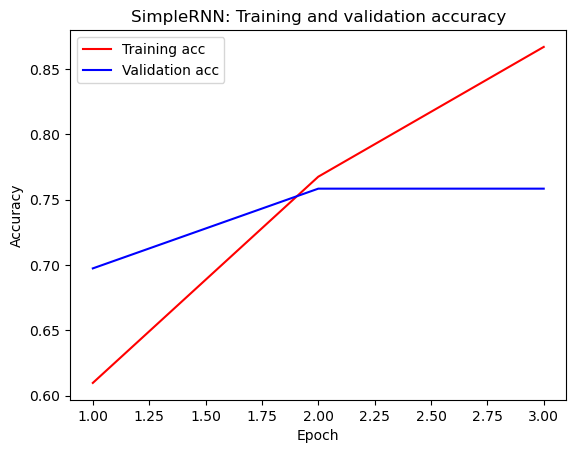

In [113]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

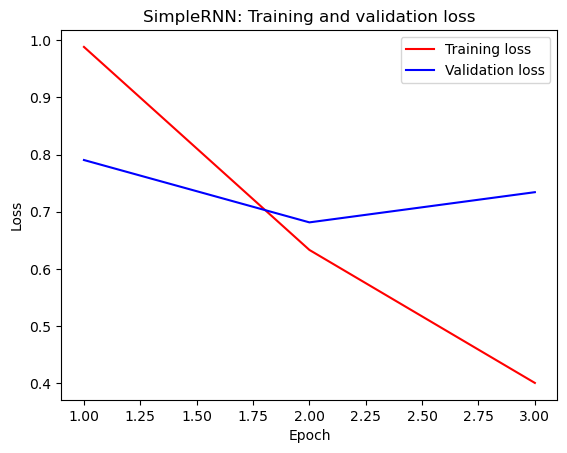

In [114]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

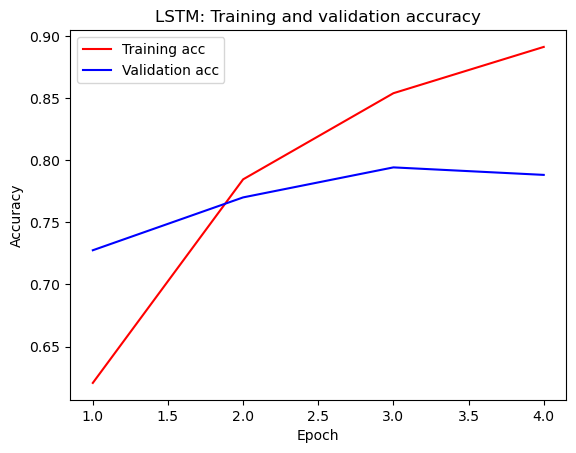

In [115]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

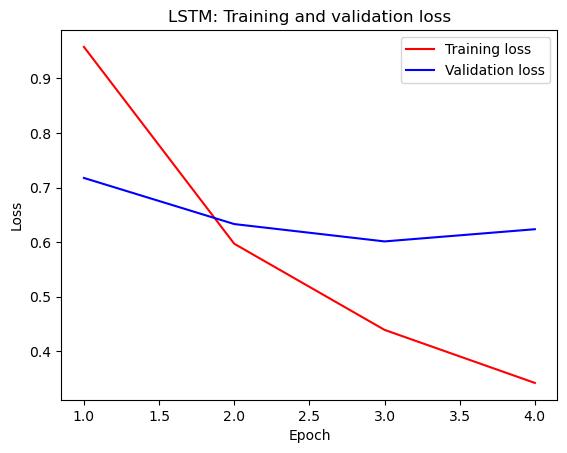

In [116]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

In [117]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [118]:
lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 28, 32)            370560    
                                                                 
 lstm_6 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_10 (Dropout)        (None, 28, 32)            0         
                                                                 
 lstm_7 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_11 (Dropout)        (None, 28, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 4)                

In [119]:
predictions = lstm.predict(X_test)

170/170 [==============================] - 4s 16ms/step


In [120]:
probability_positive = predictions[:,1]

In [121]:
len(probability_positive)

5433

In [122]:
probability_positive

array([0.2519881 , 0.24980778, 0.249358  , ..., 0.25043663, 0.2497904 ,
       0.24970877], dtype=float32)